In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Autoencoders** are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. 

Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.

<hr />

<h5>Connect with the Author of this Notebook <a href="https://linkedin.com/in/rocky-jagtiani-3b390649/">here.</a> 
    <br /> Mr. Rocky Jagtiani works as a Head for Training & Content Development at <a href="https://datascience.suvenconsultants.com/">Suven Consultants & Technology Pvt ltd.</a> </h5>
    
<hr />

![Autoencoder concept diagram](https://drive.google.com/uc?id=1jVwyxbaF8vitrUxL5brfFziiaRsEyFZ1)


As visualized above, we can take an unlabeled dataset and frame it as a supervised learning problem tasked with outputting x^, a reconstruction of the original input x. This network can be trained by minimizing the reconstruction error, **`L(x,x^)`**, which measures the differences between our original input and the consequent reconstruction. The bottleneck is a key attribute of our network design; without the presence of an information bottleneck, our network could easily learn to simply memorize the input values by passing these values along through the network

So, upto we `theoritically` know that **Autoencoder is a type of neural network that can be used to learn a compressed representation of raw data**.

An autoencoder is composed of an encoder and a decoder sub-models. The encoder compresses the input and the decoder attempts to recreate the input from the compressed version provided by the encoder. After training, the encoder model is saved and the decoder is discarded.

The encoder can then be used as a **`data preparation`** technique to perform feature extraction on raw data that can be used to train a different machine learning model.

<h3>In this Notebook, you will learn how to develop and evaluate an autoencoder for classification predictive modeling. </h3>

After completing this Note book , you will know:

> An autoencoder is a neural network model that can be used to learn a compressed representation of raw data.

> How to train an autoencoder model on a training dataset and save just the encoder part of the model.

> How to use the encoder as a data preparation step when training a machine learning model.

This tutorial Notebook is divided into two parts; they are:

> Autoencoders for Feature Extraction

> Encoder as Data Preparation for Predictive Model

<hr />

## Autoencoders for Feature Extraction

We will develop an autoencoder to learn a compressed representation of the input features for a classification predictive modeling problem.

First, let’s define a classification predictive modeling problem.

We will use the `make_classification()` scikit-learn function to define a synthetic binary (2-class) classification task with 100 input features (columns) and 1,000 examples (rows). Importantly, we will define the problem in such a way that most of the input variables are redundant (90 of the 100 or 90 percent), **`allowing the autoencoder later to learn a useful compressed representation`**.

The code below defines the dataset and summarizes its shape.


In [2]:
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# summarize the dataset
print(X.shape, y.shape)

# recording the n(columns) to use later
n_inputs = X.shape[1]

print(y[:5])

(1000, 100) (1000,)
[1 0 0 1 0]


**Next, we will develop a Multilayer Perceptron (MLP) autoencoder model**.

<font color='dark greeen'><b>The model will take all of the input columns, then output the same values. It will learn to recreate the input pattern exactly.</b></font>

The autoencoder consists of two parts: the encoder and the decoder. The encoder learns how to interpret the input and compress it to an internal representation defined by the bottleneck layer. The decoder takes the output of the encoder (the bottleneck layer) and attempts to recreate the input.

Once the autoencoder is trained, the decoder is discarded and we only keep the encoder and use it to compress examples of input to vectors output by the bottleneck layer.

<font color='dark greeen'><b>In this first autoencoder, we won’t compress the input at all and will use a bottleneck layer the same size as the input. This should be an easy problem that the model will learn nearly perfectly and is intended to confirm our model is implemented correctly or not !!. </b></font>

In [3]:
## Prior to defining and fitting the model, 
## we will split the data into train and test sets 
## and scale the input data by normalizing the values to the range 0-1, 
## a good practice with MLPs.


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

We will define the encoder to have two hidden layers, the first with two times the number of inputs (e.g. 200) and the second with the same number of inputs (100), followed by the bottleneck layer with the same number of inputs as the dataset (100).

To ensure the model learns well, we will use batch normalization and leaky ReLU activation.

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs * 2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

**`The decoder will be defined with a similar structure, although in reverse`**.

It will have two hidden layers, the first with the number of inputs in the dataset (e.g. 100) and the second with double the number of inputs (e.g. 200). The output layer will have the same number of nodes as there are columns in the input data and will use a linear activation function to output numeric values.

In [5]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

The model will be fit using the efficient **`Adam version`** of stochastic gradient descent and minimizes the mean squared error, given that reconstruction is a type of **`multi-output regression`** problem.

In [6]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [12]:
## We can plot the layers in the autoencoder model to get a feeling for how the data flows through the model.

# plot the autoencoder
from tensorflow.keras.utils import plot_model
plot_model(model, 'autoencoder_no_compress.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [8]:
## Next, we can train the model to reproduce the input and keep track of the performance of the model 
## on the hold-out test set.

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=0, validation_data=(X_test,X_test))

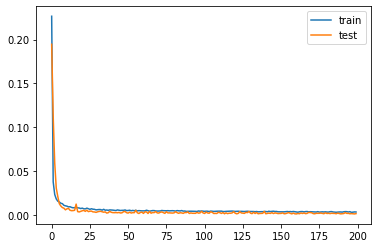

In [9]:
## After training, we can plot the learning curves for the train and test sets to confirm the model learned 
## the reconstruction problem well.

from matplotlib import pyplot

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

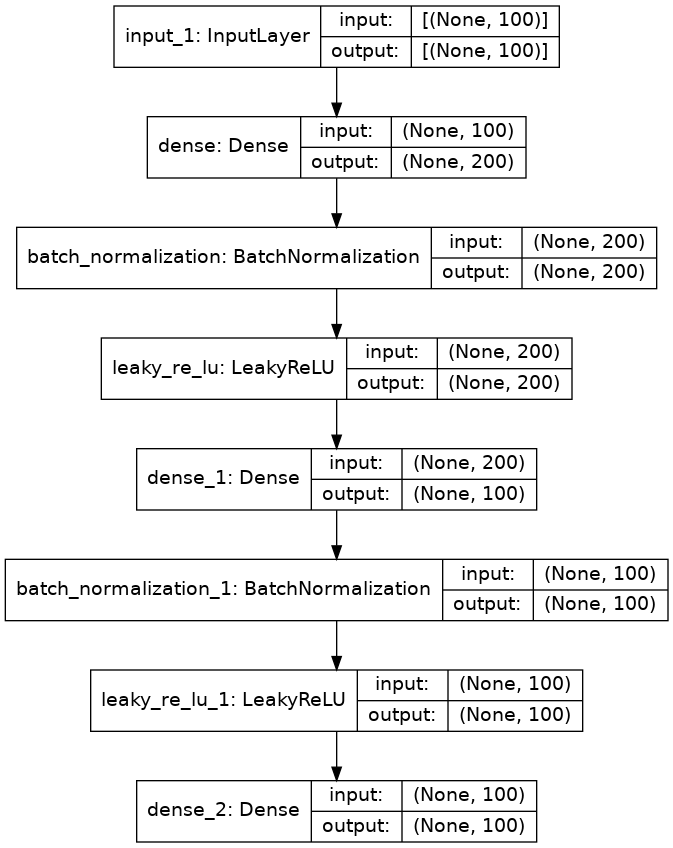

In [10]:
## Finally, we can save the encoder model for use later. We would need it !!

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)

In [11]:
# save the encoder to file
encoder.save('encoder.h5')
## https://fileinfo.com/extension/h5

<h3> So far, so good. We know how to develop an autoencoder without compression. </h3>

Next, let’s change the configuration of the model so that the bottleneck layer has half the number of nodes (e.g. 50). Also try with 25 and 10 nodes in the bottleneck layer.

Epoch 1/200
42/42 - 1s - loss: 0.2295 - val_loss: 0.1807
Epoch 2/200
42/42 - 0s - loss: 0.0346 - val_loss: 0.1109
Epoch 3/200
42/42 - 0s - loss: 0.0225 - val_loss: 0.0635
Epoch 4/200
42/42 - 0s - loss: 0.0191 - val_loss: 0.0351
Epoch 5/200
42/42 - 0s - loss: 0.0168 - val_loss: 0.0228
Epoch 6/200
42/42 - 0s - loss: 0.0158 - val_loss: 0.0162
Epoch 7/200
42/42 - 0s - loss: 0.0141 - val_loss: 0.0125
Epoch 8/200
42/42 - 0s - loss: 0.0134 - val_loss: 0.0103
Epoch 9/200
42/42 - 0s - loss: 0.0122 - val_loss: 0.0096
Epoch 10/200
42/42 - 0s - loss: 0.0112 - val_loss: 0.0074
Epoch 11/200
42/42 - 0s - loss: 0.0120 - val_loss: 0.0072
Epoch 12/200
42/42 - 0s - loss: 0.0106 - val_loss: 0.0065
Epoch 13/200
42/42 - 0s - loss: 0.0097 - val_loss: 0.0061
Epoch 14/200
42/42 - 0s - loss: 0.0096 - val_loss: 0.0078
Epoch 15/200
42/42 - 0s - loss: 0.0098 - val_loss: 0.0060
Epoch 16/200
42/42 - 0s - loss: 0.0091 - val_loss: 0.0059
Epoch 17/200
42/42 - 0s - loss: 0.0084 - val_loss: 0.0085
Epoch 18/200
42/42 - 0s

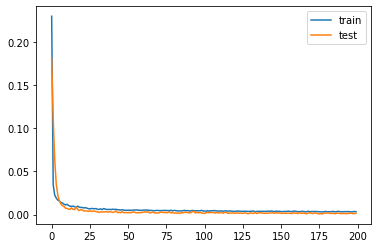

In [15]:
# train autoencoder for classification with compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot

# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)

# number of input columns
n_inputs = X.shape[1]

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = round(float(n_inputs) / 10.0)   ## NOTE this carefully !!
bottleneck = Dense(n_bottleneck)(e)

# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder_compress.png', show_shapes=True)

# save the encoder to file
encoder.save('encoder.h5')

In this case, **`we see that loss gets similarly low as the above example without compression, suggesting that perhaps the model performs just as well with a bottleneck half the size`**.

A plot of the learning curves is created, again showing that the model achieves a good fit in reconstructing the input, which holds steady throughout training, not overfitting.

## Encoder as Data Preparation for Predictive Model

We will `use the trained encoder` from the autoencoder to compress input data and train a different predictive model.

First, let’s establish a baseline in performance on this problem. This is important as if the performance of a model is not improved by the compressed encoding, then the compressed encoding does not add value to the project and should not be used.

We can train a logistic regression model on the training dataset directly and evaluate the performance of the model on the holdout test set.

In [13]:
# baseline in performance with logistic regression model
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# define model
model = LogisticRegression()

# fit model on training set
model.fit(X_train, y_train)

# make prediction on test set
yhat = model.predict(X_test)

# calculate accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8939393939393939


**`In this case, we can see that the model achieves a classification accuracy of about 89.3 percent`**.

We would hope and expect that a logistic regression model fit on an encoded version of the input to achieve better accuracy for the encoding to be considered useful.

In [14]:
# evaluate logistic regression on encoded input
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# load the model from file
encoder = load_model('encoder.h5')

## We can then use the encoder to transform the raw input data (e.g. 100 columns) 
## into bottleneck vectors (e.g. 50 element vectors).
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
## So effectively , its like dimensinality reduction or feature extraction

# define the model
model = LogisticRegression(max_iter = 200)  
## specifying max_iter = 200 , to avoid the CONVERGENCE WARNING
## Why do we get CONVERGENCE WARNING ?
## because the model has converged already , but our loop is still training ovwr many epochs.
## Reduce the epochs

# fit the model on the training set
model.fit(X_train_encode, y_train)

# make predictions on the test set
yhat = model.predict(X_test_encode)

# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

0.8909090909090909


`In this case, we can see that the model achieves a classification accuracy of about ~ 93 or 94 percent.`

This is a better classification accuracy than the same model evaluated on the raw dataset, **`suggesting that the encoding is helpful for our chosen model`** 

## Summary 

1. We know WHAT are Auto Encoders -> They are 2 models combined -> Encoder + Decoder 

2. We understood WHY Autoencoders are used -> mainly for feature extraction -> finding important features which describe the data best

3. We understood WHERE to use it -> by solving a simple CLASSIFICATION problem feeding it data encoded by an Trained Autoencoder

4. Other Applications of Autoencoders are like : 

> Image Compression

> Image Denoising

> Image generation

> Sequence to sequence prediction

> Recommendation system

<hr />

<h4>We can be connected over on Linkedin  <a href="linkedin.com/in/rocky-jagtiani-3b390649/">here.</a></h4>

<hr />

More Reading : <br />
https://iq.opengenus.org/applications-of-autoencoders/